In [7]:
# Import libraries
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fftarray as fa
from astropy.timeseries import LombScargle
from scipy.signal import detrend, find_peaks
import holidays
import plotly.graph_objects as go

In [8]:
data_dir = '../Data/'
data_dict = {}

for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        # Exemple de nom de fichier : steamdb_chart_cs2_players.csv
        match = re.search(r"steamdb_chart_(.*?)_", file)
        if match:
            name = match.group(1)  # extrait "cs2"
            print(name)
            df = pd.read_csv(os.path.join(data_dir, file),sep=';')
            df["Source"] = name
            data_dict[name] = df
        else:
            print(f"Nom de fichier ignoré : {file}")



data


In [9]:
df.columns

Index(['DateTime', 'Users', 'Average Users', 'In-Game', 'Source'], dtype='object')

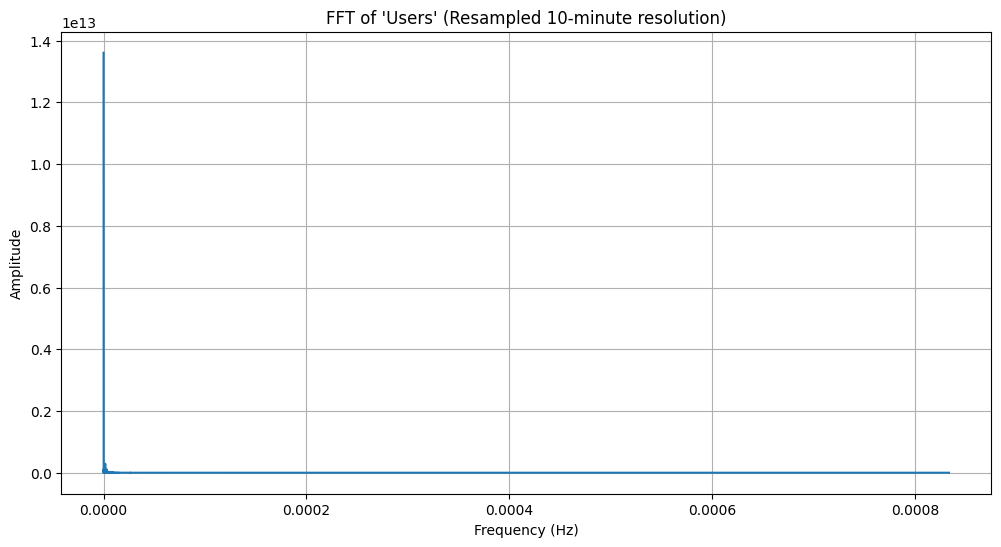

In [10]:
tempdf = df.copy()
# Step 1: Convert to datetime and set index
tempdf["DateTime"] = pd.to_datetime(tempdf["DateTime"])
tempdf.set_index("DateTime", inplace=True)

# Step 2: Interpolate missing 'Users' data
tempdf["Users"] = pd.to_numeric(tempdf["Users"], errors="coerce")
tempdf["Users"] = tempdf["Users"].interpolate(method="time")  # time-based interpolation

# Step 3: Resample to uniform 10-minute intervals
tempdf_resampled = tempdf["Users"].resample("10min").interpolate(method="linear")

# Step 4: Apply FFT using fftarray
users_array = tempdf_resampled.values
fft_result = np.fft.fft(users_array)


# Step 5: Frequency axis
n = len(users_array)
timestep = 600  # 10 minutes in seconds
freq = np.fft.fftfreq(n, d=timestep)
amplitude = abs(fft_result)

# Step 6: Plot (only positive frequencies)
mask = freq >= 0
plt.figure(figsize=(12,6))
plt.plot(freq[mask], amplitude[mask])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of 'Users' (Resampled 10-minute resolution)")
plt.grid(True)
plt.show()


In [11]:
print(df.columns)

Index(['DateTime', 'Users', 'Average Users', 'In-Game', 'Source'], dtype='object')


# Lomb-Scargle periodgram

Dominant daily signal masks smaller ones

The 24 h (1.16 × 10⁻⁵ Hz) and 12 h (2.31 × 10⁻⁵ Hz) cycles are extremely strong — they dominate the variance.
Lomb–Scargle (and FFT) are energy-based methods: if one periodicity explains most of the variation, smaller, slower cycles (like weekly) get buried unless you remove the large one first.

→ Think of it like audio:
A loud 24 h “tone” drowns out a faint 7-day “bass line.”

Filtered dataset: 2520 points, from 2023-01-01 00:00:00 to 2025-11-10 00:00:00
datetime64[ns]


C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\636266273.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = pd.to_numeric(df_ls_2["Users"], errors="coerce").fillna(method="ffill").values


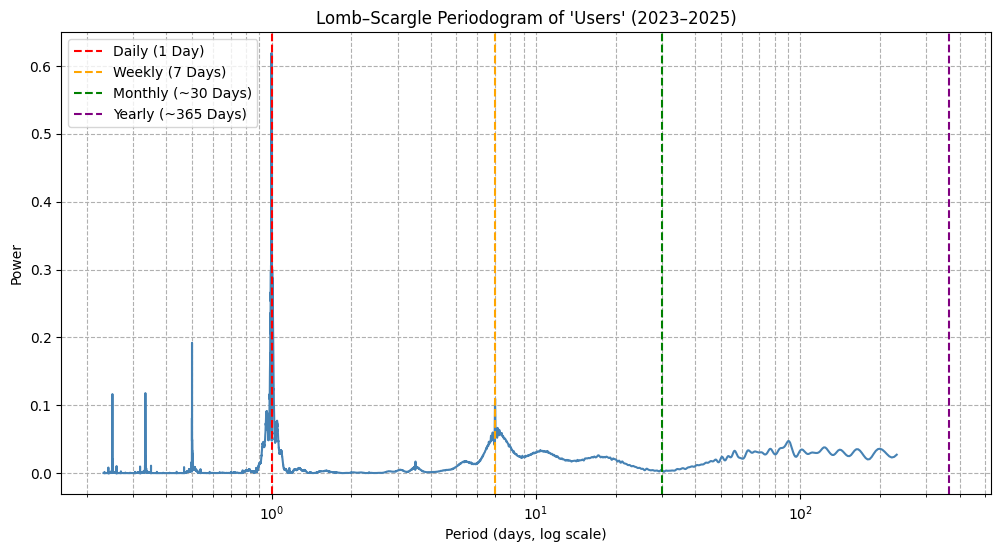

Peak 1: Frequency = 1.158638e-05 Hz → 23.97 h (1.00 days), Power = 0.619
Peak 2: Frequency = 1.158527e-05 Hz → 23.98 h (1.00 days), Power = 0.606
Peak 3: Frequency = 1.158749e-05 Hz → 23.97 h (1.00 days), Power = 0.595
Peak 4: Frequency = 1.158416e-05 Hz → 23.98 h (1.00 days), Power = 0.574
Peak 5: Frequency = 1.158305e-05 Hz → 23.98 h (1.00 days), Power = 0.537
Peak 6: Frequency = 1.158860e-05 Hz → 23.97 h (1.00 days), Power = 0.531
Peak 7: Frequency = 1.158195e-05 Hz → 23.98 h (1.00 days), Power = 0.484
Peak 8: Frequency = 1.158971e-05 Hz → 23.97 h (1.00 days), Power = 0.451
Peak 9: Frequency = 1.158084e-05 Hz → 23.99 h (1.00 days), Power = 0.405
Peak 10: Frequency = 1.159968e-05 Hz → 23.95 h (1.00 days), Power = 0.392


In [12]:
# Make a copy to preserve the original DataFrame
df_ls_2 = df.copy()

# Ensure DateTime is parsed correctly
df_ls_2["DateTime"] = pd.to_datetime(df_ls_2["DateTime"].astype(str).str.strip(), errors="coerce")

# Drop invalid or missing values
df_ls_2 = df_ls_2.dropna(subset=["DateTime", "Users"])

# Focus on 2023–2025
df_ls_2 = df_ls_2[(df_ls_2["DateTime"] >= "2023-01-01") & (df_ls_2["DateTime"] <= "2025-11-10")].copy()

print(f"Filtered dataset: {len(df_ls_2)} points, from {df_ls_2['DateTime'].min()} to {df_ls_2['DateTime'].max()}")
print(df_ls_2["DateTime"].dtype)

# Prepare data
t = (df_ls_2["DateTime"] - df_ls_2["DateTime"].min()).dt.total_seconds().values
y = pd.to_numeric(df_ls_2["Users"], errors="coerce").fillna(method="ffill").values

# Detrend to remove slow drift
y = detrend(y, type="linear")

# Lomb–Scargle computation
frequency, power = LombScargle(t, y).autopower(
    minimum_frequency=5e-8,   # ~500 days
    maximum_frequency=5e-5,   # ~5 hours
    samples_per_peak=10
)

# Convert to periods
period_days = 1 / frequency / 3600 / 24

# Plot periodogram
plt.figure(figsize=(12, 6))
plt.plot(period_days, power, color="steelblue")
plt.xscale("log")
plt.xlabel("Period (days, log scale)")
plt.ylabel("Power")
plt.title("Lomb–Scargle Periodogram of 'Users' (2023–2025)")
plt.grid(True, which="both", ls="--")

# Reference lines for known periods
plt.axvline(1, color="red", ls="--", label="Daily (1 Day)")
plt.axvline(7, color="orange", ls="--", label="Weekly (7 Days)")
plt.axvline(30, color="green", ls="--", label="Monthly (~30 Days)")
plt.axvline(365, color="purple", ls="--", label="Yearly (~365 Days)")

plt.legend()
plt.show()


# Print top peaks
peaks = np.argsort(power)[-10:][::-1]
for i in range(len(peaks)):
    f = frequency[peaks[i]]
    period_h = 1 / f / 3600
    period_d = period_h / 24
    print(f"Peak {i+1}: Frequency = {f:.6e} Hz → {period_h:.2f} h ({period_d:.2f} days), Power = {power[peaks[i]]:.3f}")


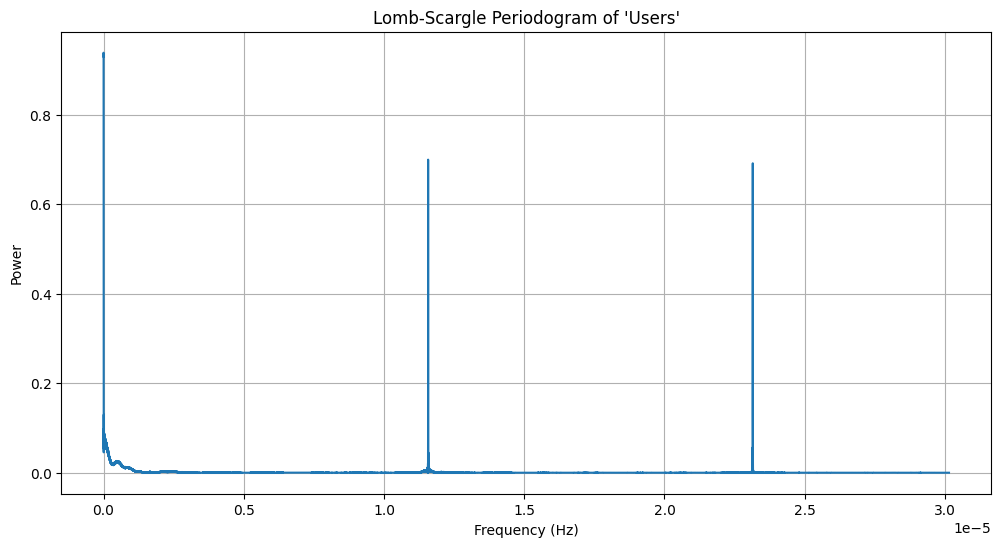

In [13]:
# Step 1: Drop NaNs
df_clean = df[["DateTime", "Users"]].dropna()
df_clean["DateTime"] = pd.to_datetime(df_clean["DateTime"])

# Step 2: Convert to seconds since start
t = (df_clean["DateTime"] - df_clean["DateTime"].min()).dt.total_seconds().values
y = df_clean["Users"].values

# Step 3: Lomb-Scargle
frequency, power = LombScargle(t, y).autopower()

# Step 4: Plot
plt.figure(figsize=(12,6))
plt.plot(frequency, power)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of 'Users'")
plt.grid(True)
plt.show()

2024 range: 2024-01-01 00:00:00 → 2024-12-31 00:00:00 (366 points)
Numeric columns used for resampling: ['Users', 'Average Users', 'In-Game']
Median time interval: 1 days 00:00:00
Resampling to 1H resolution...


C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\4282445085.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(resample_freq)


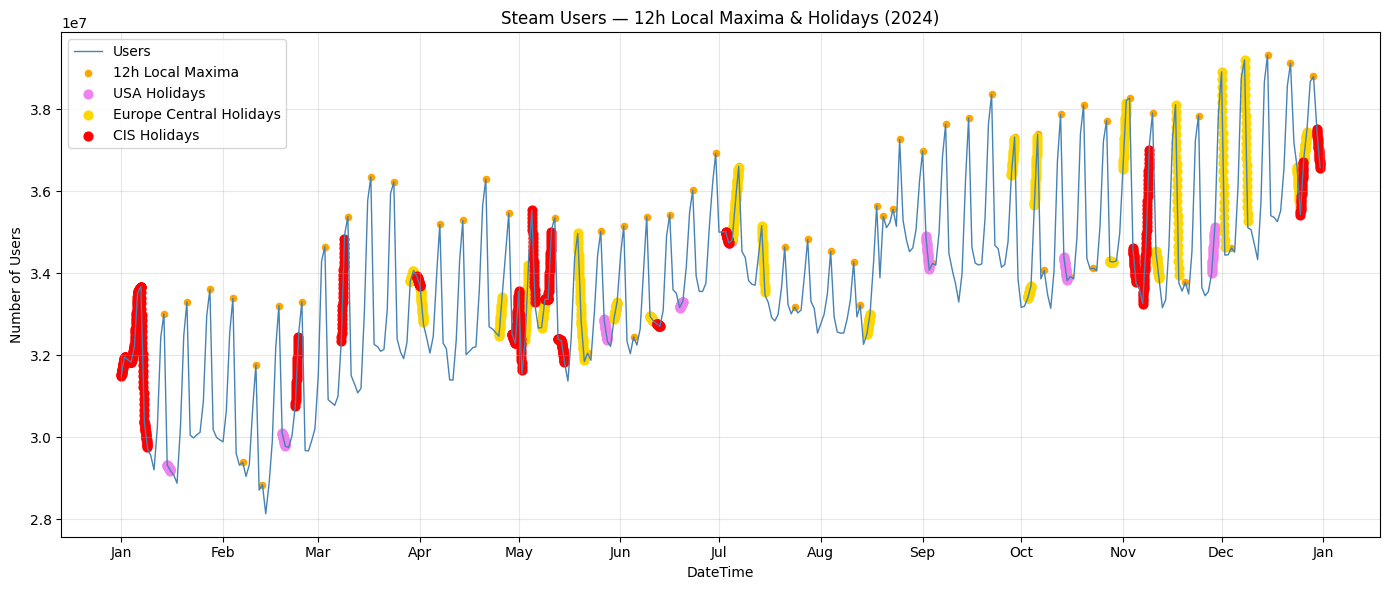

In [14]:
# --- Step 0: Create working copy ---
df_ls_holidays = df.copy()

# --- Step 1: Extract 2024 data ---
df_ls_holidays["DateTime"] = pd.to_datetime(df_ls_holidays["DateTime"])
df_2024 = df_ls_holidays[
    (df_ls_holidays["DateTime"] >= "2024-01-01") &
    (df_ls_holidays["DateTime"] < "2025-01-01")
].copy()

print(f"2024 range: {df_2024['DateTime'].min()} → {df_2024['DateTime'].max()} "
      f"({len(df_2024)} points)")

# --- Step 2: Detect median sampling frequency & safely resample ---
df_2024 = df_2024.sort_values("DateTime").set_index("DateTime")

# Check which columns are numeric
numeric_cols = df_2024.select_dtypes(include=["number"]).columns.tolist()
print(f"Numeric columns used for resampling: {numeric_cols}")

# Detect median time delta
median_freq = df_2024.index.to_series().diff().median()
print(f"Median time interval: {median_freq}")

# Decide resampling step
if median_freq <= pd.Timedelta("15min"):
    resample_freq = "10min"
else:
    resample_freq = "1H"
print(f"Resampling to {resample_freq} resolution...")

# Perform safe resampling (numeric columns only)
df_highres = (
    df_2024[numeric_cols]
    .resample(resample_freq)
    .agg("mean")
    .interpolate(method="time")
)

# --- Step 3: Detect 12h local maxima ---
from scipy.signal import find_peaks
y = df_highres["Users"].values
peaks, _ = find_peaks(y, distance=72 if resample_freq == "10min" else 12)
df_highres["is_peak_12h"] = False
df_highres.loc[df_highres.index[peaks], "is_peak_12h"] = True

# --- Step 4: Generate holidays for 2024 ---
import holidays
regions = {
    "USA": holidays.US(years=[2024]),
    "Europe_Central": (
        holidays.CZ(years=[2024]) + holidays.DE(years=[2024]) +
        holidays.FR(years=[2024]) + holidays.PT(years=[2024]) +
        holidays.PL(years=[2024])
    ),
    "CIS": holidays.RU(years=[2024]) + holidays.UA(years=[2024]) + holidays.BY(years=[2024])
}

# Tag holidays in df_highres
df_highres["Holiday_Region"] = None
for region, cal in regions.items():
    for date in cal.keys():
        mask = df_highres.index.date == pd.Timestamp(date).date()
        df_highres.loc[mask, "Holiday_Region"] = region

# --- Step 5: Plot ---
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_highres.index, df_highres["Users"], label="Users", color="steelblue", linewidth=1)

# 12h maxima
plt.scatter(
    df_highres.index[df_highres["is_peak_12h"]],
    df_highres["Users"][df_highres["is_peak_12h"]],
    color="orange", s=20, label="12h Local Maxima"
)

# Holidays by region
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "USA"],
    df_highres["Users"][df_highres["Holiday_Region"] == "USA"],
    color="violet", s=40, label="USA Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "Europe_Central"],
    df_highres["Users"][df_highres["Holiday_Region"] == "Europe_Central"],
    color="gold", s=40, label="Europe Central Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "CIS"],
    df_highres["Users"][df_highres["Holiday_Region"] == "CIS"],
    color="red", s=40, label="CIS Holidays"
)

# Formatting
plt.title("Steam Users — 12h Local Maxima & Holidays (2024)")
plt.xlabel("DateTime")
plt.ylabel("Number of Users")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.tight_layout()
plt.show()


2024 range: 2024-01-01 00:00:00 → 2024-12-31 00:00:00 (366 points)
Numeric columns used for resampling: ['Users', 'Average Users', 'In-Game']
Resampled to 8761 points at 1H resolution.


C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\2777430158.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


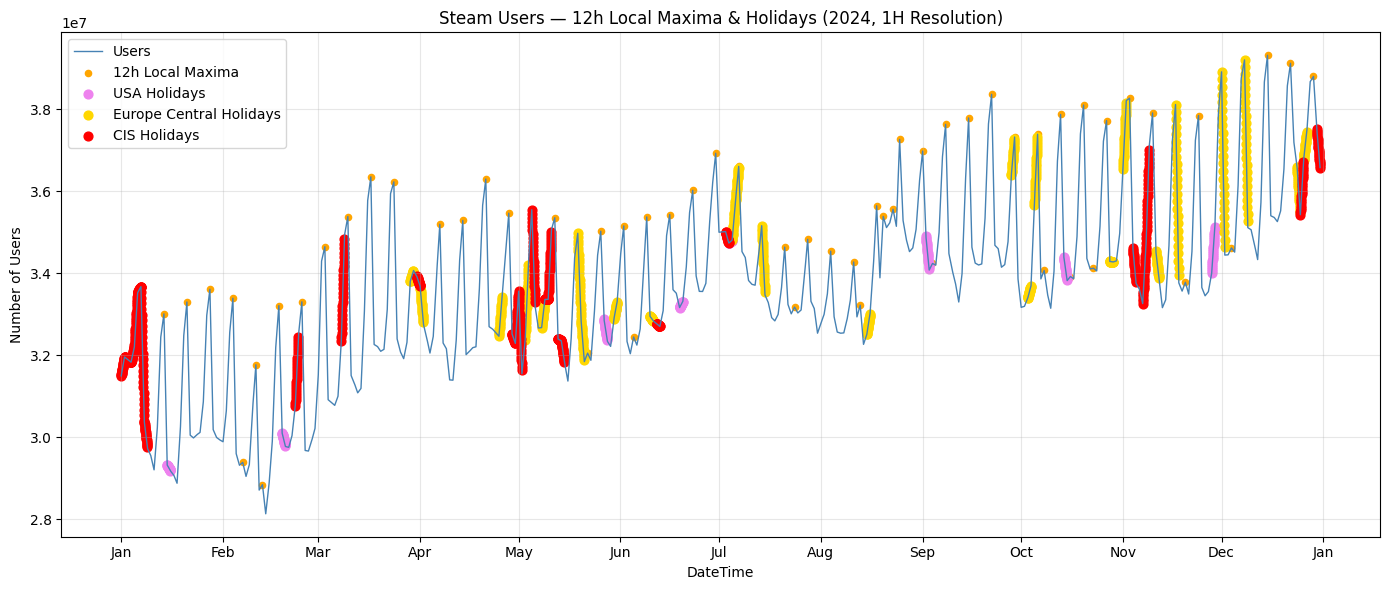

In [15]:
# --- Step 0: Create working copy ---
df_ls_holidays = df.copy()

# --- Step 1: Extract 2024 data ---
df_ls_holidays["DateTime"] = pd.to_datetime(df_ls_holidays["DateTime"])
df_2024 = df_ls_holidays[
    (df_ls_holidays["DateTime"] >= "2024-01-01") &
    (df_ls_holidays["DateTime"] < "2025-01-01")
].copy()

print(f"2024 range: {df_2024['DateTime'].min()} → {df_2024['DateTime'].max()} "
      f"({len(df_2024)} points)")

# --- Step 2: Force uniform hourly resolution ---
df_2024 = df_2024.sort_values("DateTime").set_index("DateTime")
numeric_cols = df_2024.select_dtypes(include=["number"]).columns.tolist()
print(f"Numeric columns used for resampling: {numeric_cols}")

df_highres = (
    df_2024[numeric_cols]
    .resample("1H")
    .mean()
    .interpolate(method="time")
)

print(f"Resampled to {len(df_highres)} points at 1H resolution.")

# --- Step 3: Detect 12h local maxima ---
from scipy.signal import find_peaks

y = df_highres["Users"].values
# 12h distance = 12 data points (since we’re at 1H frequency)
peaks, _ = find_peaks(y, distance=12)

df_highres["is_peak_12h"] = False
df_highres.loc[df_highres.index[peaks], "is_peak_12h"] = True

# --- Step 4: Generate holidays for 2024 ---
import holidays

regions = {
    "USA": holidays.US(years=[2024]),
    "Europe_Central": (
        holidays.CZ(years=[2024]) + holidays.DE(years=[2024]) +
        holidays.FR(years=[2024]) + holidays.PT(years=[2024]) +
        holidays.PL(years=[2024])
    ),
    "CIS": holidays.RU(years=[2024]) + holidays.UA(years=[2024]) + holidays.BY(years=[2024])
}

df_highres["Holiday_Region"] = None
for region, cal in regions.items():
    for date in cal.keys():
        mask = df_highres.index.date == pd.Timestamp(date).date()
        df_highres.loc[mask, "Holiday_Region"] = region

# --- Step 5: Plot ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
plt.plot(df_highres.index, df_highres["Users"], label="Users", color="steelblue", linewidth=1)

# 12h maxima
plt.scatter(
    df_highres.index[df_highres["is_peak_12h"]],
    df_highres["Users"][df_highres["is_peak_12h"]],
    color="orange", s=20, label="12h Local Maxima"
)

# Holidays by region
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "USA"],
    df_highres["Users"][df_highres["Holiday_Region"] == "USA"],
    color="violet", s=40, label="USA Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "Europe_Central"],
    df_highres["Users"][df_highres["Holiday_Region"] == "Europe_Central"],
    color="gold", s=40, label="Europe Central Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "CIS"],
    df_highres["Users"][df_highres["Holiday_Region"] == "CIS"],
    color="red", s=40, label="CIS Holidays"
)

# Formatting
plt.title("Steam Users — 12h Local Maxima & Holidays (2024, 1H Resolution)")
plt.xlabel("DateTime")
plt.ylabel("Number of Users")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.tight_layout()
plt.show()


2025 range: 2025-01-01 00:00:00 → 2025-11-10 11:20:00 (1857 points)


C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\247770095.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


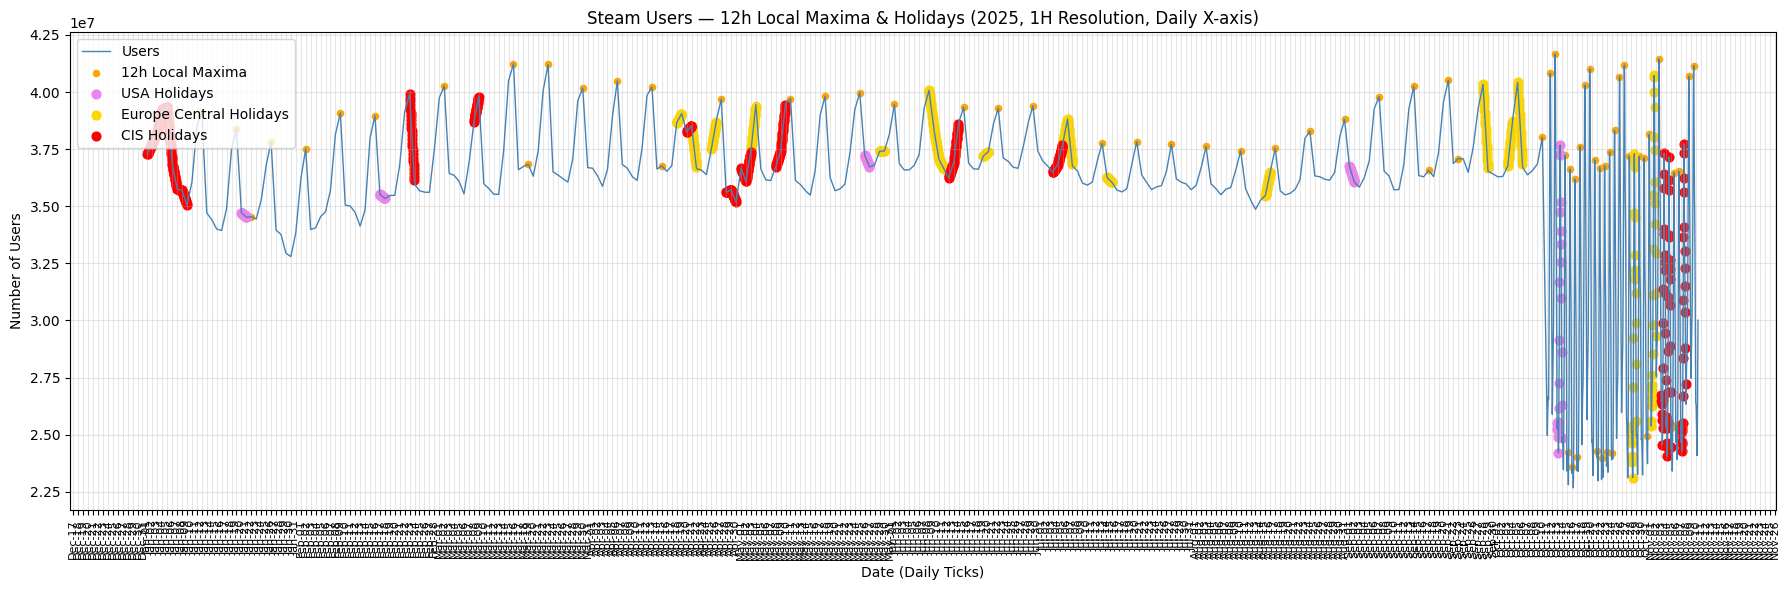

In [16]:
# --- Step 0: Create working copy ---
df_ls_holidays = df.copy()

# --- Step 1: Extract 2025 data ---
df_ls_holidays["DateTime"] = pd.to_datetime(df_ls_holidays["DateTime"])
end_date = df_ls_holidays["DateTime"].max()

df_2025 = df_ls_holidays[
    (df_ls_holidays["DateTime"] >= "2025-01-01") &
    (df_ls_holidays["DateTime"] <= end_date)
].copy()

print(f"2025 range: {df_2025['DateTime'].min()} → {df_2025['DateTime'].max()} "
      f"({len(df_2025)} points)")

# --- Step 2: Resample to hourly frequency ---
df_2025 = df_2025.sort_values("DateTime").set_index("DateTime")
numeric_cols = df_2025.select_dtypes(include=["number"]).columns.tolist()

df_highres = (
    df_2025[numeric_cols]
    .resample("1H")
    .mean()
    .interpolate(method="time")
)

# --- Step 3: Detect 12h local maxima ---
from scipy.signal import find_peaks

y = df_highres["Users"].values
# 12 data points = 12 hours at 1H sampling
peaks, _ = find_peaks(y, distance=12)
df_highres["is_peak_12h"] = False
df_highres.loc[df_highres.index[peaks], "is_peak_12h"] = True

# --- Step 4: Generate holidays for 2025 ---
import holidays

regions = {
    "USA": holidays.US(years=[2025]),
    "Europe_Central": (
        holidays.CZ(years=[2025]) + holidays.DE(years=[2025]) +
        holidays.FR(years=[2025]) + holidays.PT(years=[2025]) +
        holidays.PL(years=[2025])
    ),
    "CIS": holidays.RU(years=[2025]) + holidays.UA(years=[2025]) + holidays.BY(years=[2025])
}

df_highres["Holiday_Region"] = None
for region, cal in regions.items():
    for date in cal.keys():
        mask = df_highres.index.date == pd.Timestamp(date).date()
        df_highres.loc[mask, "Holiday_Region"] = region

# --- Step 5: Plot with daily ticks ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(18, 6))
plt.plot(df_highres.index, df_highres["Users"], label="Users", color="steelblue", linewidth=1)

# 12h maxima
plt.scatter(
    df_highres.index[df_highres["is_peak_12h"]],
    df_highres["Users"][df_highres["is_peak_12h"]],
    color="orange", s=20, label="12h Local Maxima"
)

# Holidays by region
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "USA"],
    df_highres["Users"][df_highres["Holiday_Region"] == "USA"],
    color="violet", s=40, label="USA Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "Europe_Central"],
    df_highres["Users"][df_highres["Holiday_Region"] == "Europe_Central"],
    color="gold", s=40, label="Europe Central Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "CIS"],
    df_highres["Users"][df_highres["Holiday_Region"] == "CIS"],
    color="red", s=40, label="CIS Holidays"
)

# --- Formatting: show each day ---
plt.title("Steam Users — 12h Local Maxima & Holidays (2025, 1H Resolution, Daily X-axis)")
plt.xlabel("Date (Daily Ticks)")
plt.ylabel("Number of Users")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

# Daily ticks on X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()


Using data from 2025-10-11 12:00:00 → 2025-11-10 11:20:00 (1562 points)


C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\254404466.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


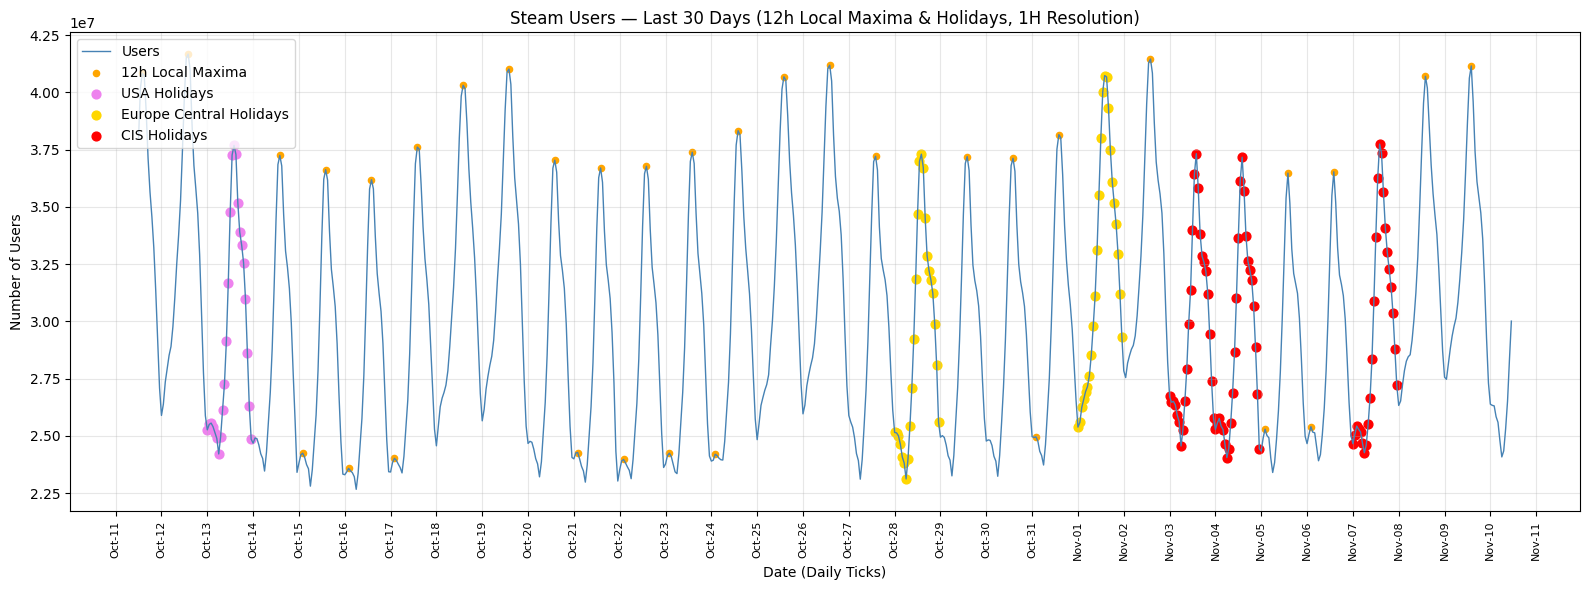

In [17]:
# --- Step 0: Create working copy ---
df_ls_holidays = df.copy()

# --- Step 1: Extract last month of 2025 ---
df_ls_holidays["DateTime"] = pd.to_datetime(df_ls_holidays["DateTime"])

end_date = df_ls_holidays["DateTime"].max()
start_date = end_date - pd.Timedelta(days=30)

df_2025 = df_ls_holidays[
    (df_ls_holidays["DateTime"] >= start_date) &
    (df_ls_holidays["DateTime"] <= end_date)
].copy()

print(f"Using data from {df_2025['DateTime'].min()} → {df_2025['DateTime'].max()} "
      f"({len(df_2025)} points)")

# --- Step 2: Resample to hourly frequency ---
df_2025 = df_2025.sort_values("DateTime").set_index("DateTime")
numeric_cols = df_2025.select_dtypes(include=["number"]).columns.tolist()

df_highres = (
    df_2025[numeric_cols]
    .resample("1H")
    .mean()
    .interpolate(method="time")
)

# --- Step 3: Detect 12h local maxima ---
from scipy.signal import find_peaks

y = df_highres["Users"].values
peaks, _ = find_peaks(y, distance=12)  # 12h apart
df_highres["is_peak_12h"] = False
df_highres.loc[df_highres.index[peaks], "is_peak_12h"] = True

# --- Step 4: Generate holidays for 2025 ---
import holidays

regions = {
    "USA": holidays.US(years=[2025]),
    "Europe_Central": (
        holidays.CZ(years=[2025]) + holidays.DE(years=[2025]) +
        holidays.FR(years=[2025]) + holidays.PT(years=[2025]) +
        holidays.PL(years=[2025])
    ),
    "CIS": holidays.RU(years=[2025]) + holidays.UA(years=[2025]) + holidays.BY(years=[2025])
}

df_highres["Holiday_Region"] = None
for region, cal in regions.items():
    for date in cal.keys():
        mask = df_highres.index.date == pd.Timestamp(date).date()
        df_highres.loc[mask, "Holiday_Region"] = region

# --- Step 5: Plot (daily ticks, last 30 days) ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(16, 6))
plt.plot(df_highres.index, df_highres["Users"], label="Users", color="steelblue", linewidth=1)

# 12h maxima
plt.scatter(
    df_highres.index[df_highres["is_peak_12h"]],
    df_highres["Users"][df_highres["is_peak_12h"]],
    color="orange", s=20, label="12h Local Maxima"
)

# Holidays by region
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "USA"],
    df_highres["Users"][df_highres["Holiday_Region"] == "USA"],
    color="violet", s=40, label="USA Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "Europe_Central"],
    df_highres["Users"][df_highres["Holiday_Region"] == "Europe_Central"],
    color="gold", s=40, label="Europe Central Holidays"
)
plt.scatter(
    df_highres.index[df_highres["Holiday_Region"] == "CIS"],
    df_highres["Users"][df_highres["Holiday_Region"] == "CIS"],
    color="red", s=40, label="CIS Holidays"
)

# --- Formatting ---
plt.title("Steam Users — Last 30 Days (12h Local Maxima & Holidays, 1H Resolution)")
plt.xlabel("Date (Daily Ticks)")
plt.ylabel("Number of Users")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)

# Daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()


In [18]:
fig = go.Figure()

# Line for Users
fig.add_trace(go.Scatter(
    x=df_highres.index,
    y=df_highres["Users"],
    mode="lines",
    name="Users",
    line=dict(color="steelblue")
))

# 12h maxima
fig.add_trace(go.Scatter(
    x=df_highres.index[df_highres["is_peak_12h"]],
    y=df_highres["Users"][df_highres["is_peak_12h"]],
    mode="markers",
    name="12h Local Maxima",
    marker=dict(color="orange", size=6)
))

# USA Holidays
fig.add_trace(go.Scatter(
    x=df_highres.index[df_highres["Holiday_Region"] == "USA"],
    y=df_highres["Users"][df_highres["Holiday_Region"] == "USA"],
    mode="markers",
    name="USA Holidays",
    marker=dict(color="violet", size=7)
))

# Europe Central Holidays
fig.add_trace(go.Scatter(
    x=df_highres.index[df_highres["Holiday_Region"] == "Europe_Central"],
    y=df_highres["Users"][df_highres["Holiday_Region"] == "Europe_Central"],
    mode="markers",
    name="Europe Central Holidays",
    marker=dict(color="gold", size=7)
))

# CIS Holidays
fig.add_trace(go.Scatter(
    x=df_highres.index[df_highres["Holiday_Region"] == "CIS"],
    y=df_highres["Users"][df_highres["Holiday_Region"] == "CIS"],
    mode="markers",
    name="CIS Holidays",
    marker=dict(color="red", size=7)
))

fig.update_layout(
    title="Steam Users — 12h Local Maxima & Holidays (2024)",
    xaxis_title="DateTime",
    yaxis_title="Number of Users",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(x=0.01, y=0.99),
    width=1200,
    height=600
)

# Add a range slider for scrolling
fig.update_xaxes(rangeslider_visible=True)

import plotly.io as pio
pio.renderers.default = "browser"
fig.show()


In [ ]:
#import numpy as np
#
#def power_at_period(y, t, target_hours):
#    freq_target = 1 / (target_hours * 3600)
#    return LombScargle(t, y).power(freq_target)
#
#offsets = np.arange(-12, 13, 1)  # test -12h to +12h offsets
#powers = []
#for shift in offsets:
#    shifted_t = t + shift * 3600
#    p = power_at_period(y, shifted_t, 24)
#    powers.append(p)
#
#plt.figure(figsize=(8,4))
#plt.plot(offsets, powers, marker='o')
#plt.xlabel("Time shift (hours)")
#plt.ylabel("Lomb–Scargle Power at 24h period")
#plt.title("Daily power vs timezone shift")
#plt.grid(True)
#plt.show()
#
#print(powers)


### Get weekly tail period harmonics

In [ ]:
from astropy.timeseries import LombScargle

# Compute full periodogram again (same recent slice)
freq, power = LombScargle(t, y).autopower(minimum_frequency=1e-6, maximum_frequency=1e-4)

# Convert to days
period_days = 1 / (freq * 3600 * 24)

# Identify where 7, 14, 21 days fall
for p in [7, 14, 21]:
    nearest_idx = np.argmin(np.abs(period_days - p))
    print(f"Period ~{p}d → Power = {power[nearest_idx]:.4f}")


Period ~7d → Power = 0.0973
Period ~14d → Power = 0.0917
Period ~21d → Power = 0.0917


Using data from 2025-10-27 00:00:00 to 2025-11-10 00:00:00 (1122 points)
[0.95238095 1.         0.95238095 0.9047619  0.61904762 0.61904762
 0.38095238 0.38095238 0.71428571 0.42857143 0.38095238 0.52380952
 0.38095238 0.38095238 0.42857143 0.80952381 0.80952381 0.80952381
 0.04761905 0.04761905 0.04761905 0.         0.04761905 0.04761905]


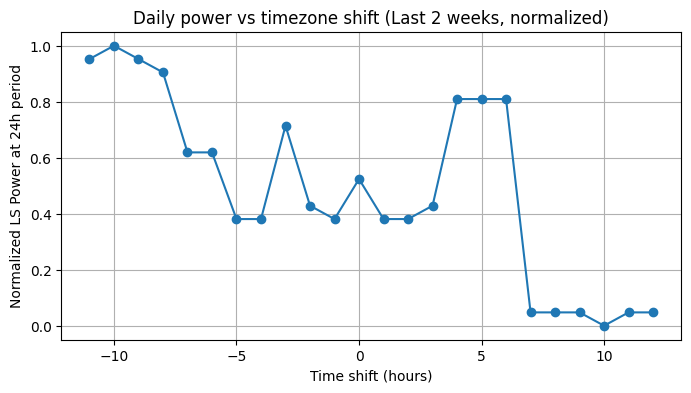

In [32]:
# --- Step 1: select the most recent 2 weeks ---
end_date = df_ls_2["DateTime"].max()
start_date = end_date - pd.Timedelta(days=14)
df_recent = df_ls_2[(df_ls_2["DateTime"] >= start_date) & (df_ls_2["DateTime"] <= end_date)].copy()

print(f"Using data from {df_recent['DateTime'].min()} to {df_recent['DateTime'].max()} ({len(df_recent)} points)")

# --- Step 2: convert to seconds since start ---
t = (df_recent["DateTime"] - df_recent["DateTime"].min()).dt.total_seconds().values
y_raw = df_recent["Users"].values

# --- Step 3: detrend + center + normalize ---
y = detrend(y_raw, type="linear")
y = y - np.mean(y)
y = y / np.std(y)

# --- Step 4: LS power at 24h for each shift ---
def power_at_period(y, t, target_hours):
    freq_target = 1 / (target_hours * 3600)
    return LombScargle(t, y).power(freq_target)

offsets = np.arange(-11, 13, 1)  # from UTC-11 to UTC+12
powers = []
for shift in offsets:
    shifted_t = t + shift * 3600
    p = power_at_period(y, shifted_t, 24)
    powers.append(p)

#normalize powers
norm_powers = (powers - np.min(powers)) / (np.max(powers) - np.min(powers))
print(norm_powers)

# --- Step 5: plot ---
plt.figure(figsize=(8,4))
plt.plot(offsets, norm_powers, marker='o')
plt.xlabel("Time shift (hours)")
plt.ylabel("Normalized LS Power at 24h period")
plt.title("Daily power vs timezone shift (Last 2 weeks, normalized)")
plt.grid(True)
plt.show()



In [47]:
#plot normalized power to timezone shifts on a map
norm_powers2 = norm_powers
applied_powers = []
j = 1

for i in range(24):
    applied_powers.append((f"UTC{i-11}",norm_powers2[i]))
print(applied_powers)

# applied_powers to table format

df_timezone_power = pd.DataFrame(applied_powers, columns=["Timezone", "Normalized_Power"])
csv_tz_power = df_timezone_power.to_csv(index=True)

print(csv_tz_power)


[('UTC-11', np.float64(0.9523809523809523)), ('UTC-10', np.float64(1.0)), ('UTC-9', np.float64(0.9523809523809523)), ('UTC-8', np.float64(0.9047619047619048)), ('UTC-7', np.float64(0.6190476190476191)), ('UTC-6', np.float64(0.6190476190476191)), ('UTC-5', np.float64(0.38095238095238093)), ('UTC-4', np.float64(0.38095238095238093)), ('UTC-3', np.float64(0.7142857142857143)), ('UTC-2', np.float64(0.42857142857142855)), ('UTC-1', np.float64(0.38095238095238093)), ('UTC0', np.float64(0.5238095238095238)), ('UTC1', np.float64(0.38095238095238093)), ('UTC2', np.float64(0.38095238095238093)), ('UTC3', np.float64(0.42857142857142855)), ('UTC4', np.float64(0.8095238095238095)), ('UTC5', np.float64(0.8095238095238095)), ('UTC6', np.float64(0.8095238095238095)), ('UTC7', np.float64(0.047619047619047616)), ('UTC8', np.float64(0.047619047619047616)), ('UTC9', np.float64(0.047619047619047616)), ('UTC10', np.float64(0.0)), ('UTC11', np.float64(0.047619047619047616)), ('UTC12', np.float64(0.0476190476

C:\Users\xenio\AppData\Local\Temp\ipykernel_16992\1484271052.py:47: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



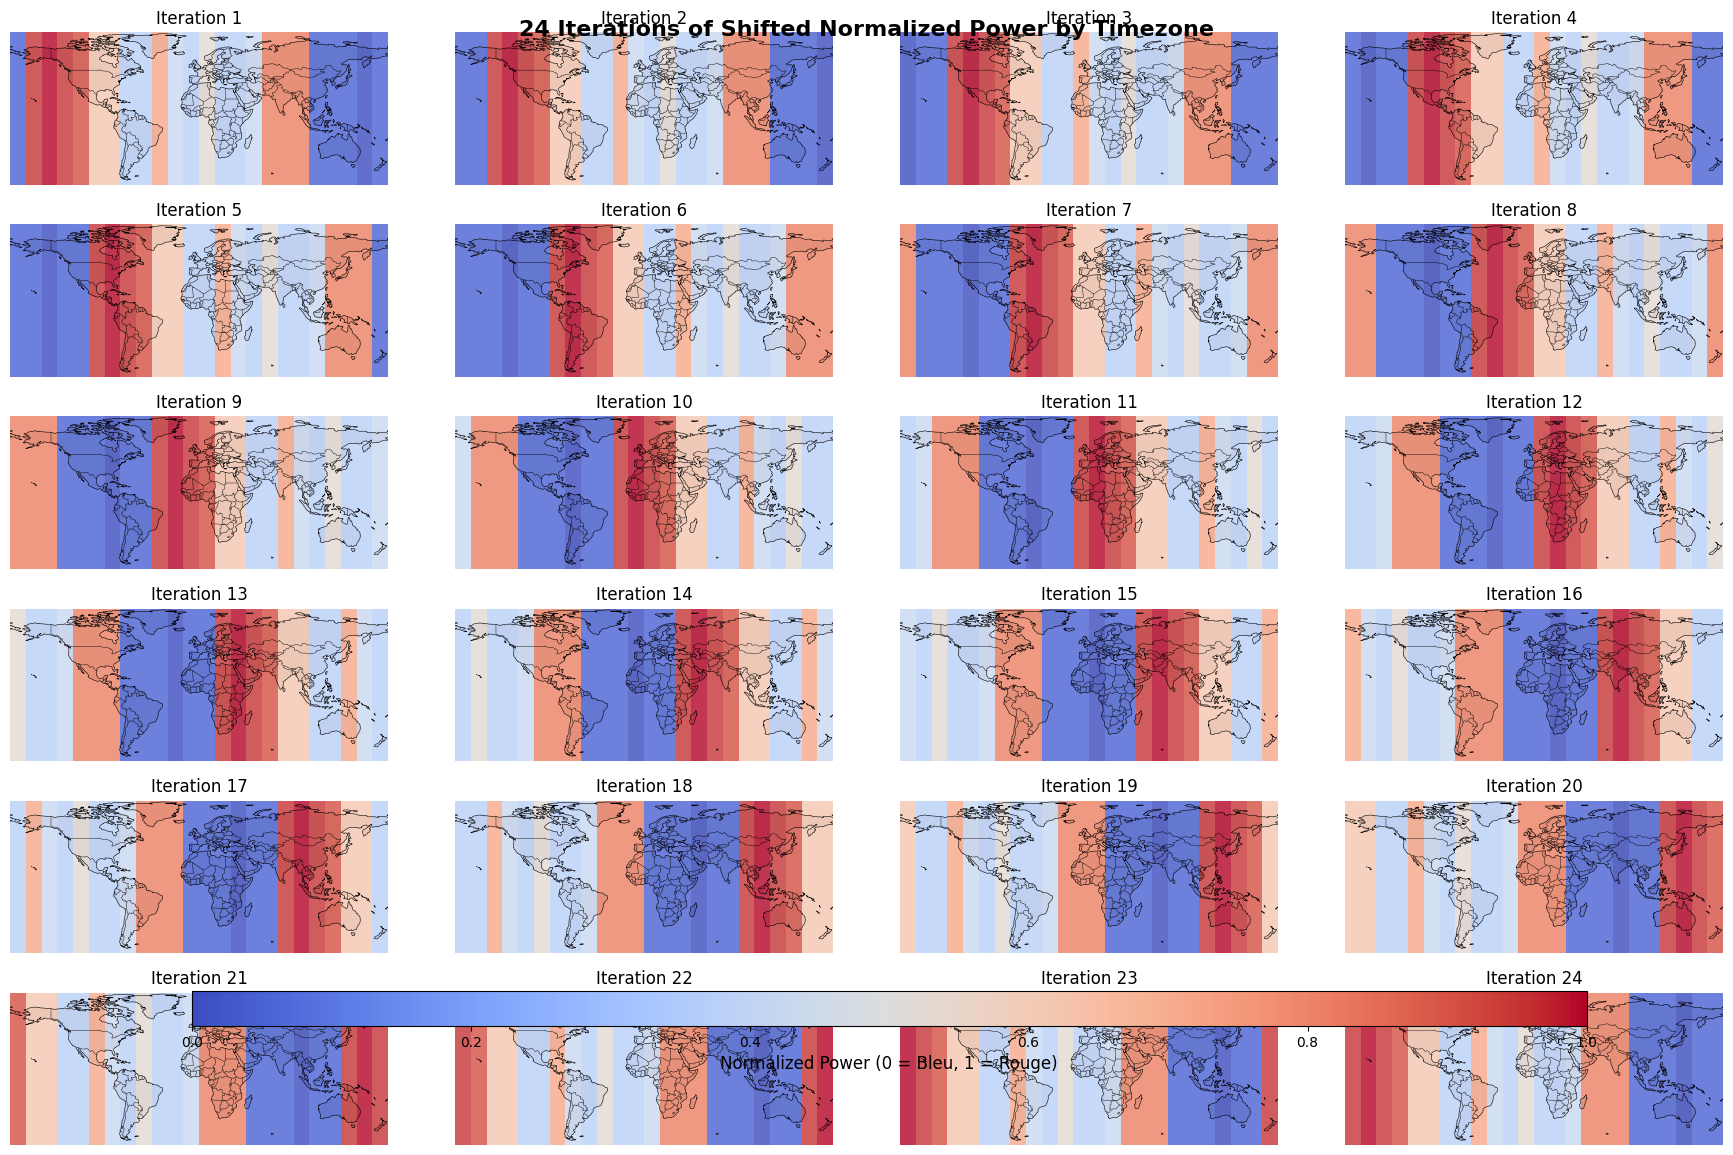

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(6, 4, figsize=(18, 12),
                         subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()

cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=1)

for i in range(24):
    shifted = df.copy()
    # ✅ cyclic shift of normalized power values
    shifted["Normalized_Power"] = np.roll(df["Normalized_Power"].values, i)
    
    ax = axes[i]
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

    for _, row in shifted.iterrows():
        lon_min = row["Timezone_int"] * 15
        lon_max = lon_min + 15
        color = cmap(norm(row["Normalized_Power"]))
        rect = Rectangle((lon_min, -90), 15, 180,
                         facecolor=color, alpha=0.8,
                         transform=ccrs.PlateCarree(), zorder=1)
        ax.add_patch(rect)

    ax.set_extent([-180, 180, -60, 85])
    ax.set_title(f"Iteration {i+1}")
    ax.axis("off")

# shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal",
                    fraction=0.04, pad=0.05, aspect=40)
cbar.set_label("Normalized Power (0 = Bleu, 1 = Rouge)", fontsize=12)

plt.suptitle("24 Iterations of Shifted Normalized Power by Timezone",
             fontsize=16, weight="bold", y=0.95)
plt.tight_layout()
plt.show()


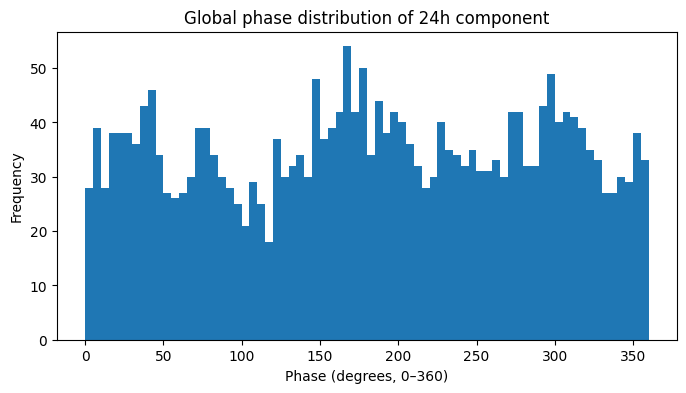

In [ ]:
from scipy.signal import hilbert

analytic_signal = hilbert(y)
instant_phase = np.angle(analytic_signal)

plt.figure(figsize=(8,4))
plt.hist(np.rad2deg(instant_phase) % 360, bins=72)
plt.xlabel("Phase (degrees, 0–360)")
plt.ylabel("Frequency")
plt.title("Global phase distribution of 24h component")
plt.show()


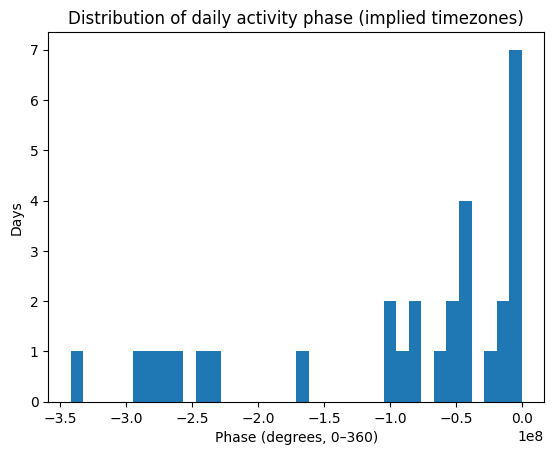

In [ ]:
from scipy.optimize import curve_fit

def daily_sine(t, A, phi, C):
    return A * np.sin(2 * np.pi * t / 86400 + phi) + C

df_ls_2["seconds_in_day"] = (df_ls_2["DateTime"].dt.hour * 3600 +
                             df_ls_2["DateTime"].dt.minute * 60)
grouped = df_ls_2.groupby(df_ls_2["DateTime"].dt.date)["seconds_in_day"].apply(list)
values = df_ls_2.groupby(df_ls_2["DateTime"].dt.date)["Users"].apply(list)

phases = []
for day, vals in zip(grouped.index, values):
    try:
        t_day = np.array(grouped[day])
        y_day = np.array(vals)
        popt, _ = curve_fit(daily_sine, t_day, y_day, p0=[1, 0, np.mean(y_day)])
        phases.append(popt[1])  # phase angle in radians
    except:
        continue

plt.hist(np.rad2deg(phases), bins=36)
plt.xlabel("Phase (degrees, 0–360)")
plt.ylabel("Days")
plt.title("Distribution of daily activity phase (implied timezones)")
plt.show()



In [ ]:
# Focus on mid-range frequencies (ignore ultra-slow trends)
mask = (frequency > 5e-7) & (frequency < 5e-5)

# Get dominant peaks in this range
freq_zoom = frequency[mask]
power_zoom = power[mask]
peaks = np.argsort(power_zoom)[-100:][::-1]

dominant_freqs = freq_zoom[peaks]
dominant_powers = power_zoom[peaks]
dominant_periods_hours = 1 / dominant_freqs / 3600
dominant_periods_days = dominant_periods_hours / 24

print("Top 5 dominant mid-range frequencies and periods:")
for i in range(len(dominant_freqs)):
    print(f"Peak {i+1}: Frequency = {dominant_freqs[i]:.6e} Hz  "
          f"→ Period = {dominant_periods_hours[i]:.2f} h ({dominant_periods_days[i]:.2f} days), "
          f"Power = {dominant_powers[i]:.3f}")


Top 5 dominant mid-range frequencies and periods:
Peak 1: Frequency = 1.157353e-05 Hz  → Period = 24.00 h (1.00 days), Power = 0.700
Peak 2: Frequency = 2.314895e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.691
Peak 3: Frequency = 2.314866e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.689
Peak 4: Frequency = 2.314750e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.649
Peak 5: Frequency = 1.157324e-05 Hz  → Period = 24.00 h (1.00 days), Power = 0.637
Peak 6: Frequency = 2.314721e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.633
Peak 7: Frequency = 2.314925e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.589
Peak 8: Frequency = 2.314692e-05 Hz  → Period = 12.00 h (0.50 days), Power = 0.546
Peak 9: Frequency = 1.157382e-05 Hz  → Period = 24.00 h (1.00 days), Power = 0.544
Peak 10: Frequency = 1.157499e-05 Hz  → Period = 24.00 h (1.00 days), Power = 0.531
Peak 11: Frequency = 1.157470e-05 Hz  → Period = 24.00 h (1.00 days), Power = 0.524
Peak 12: Frequency = 2.314779e-05 H